# Explicación de variables por gesto


<div style="text-align: center;">
<img src="../Imagenes/gestures.png" width="500"/>
</div>

In [1]:
# importar librerias
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fn
import numpy as np

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_classif

# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

import warnings
# from sklearn.exceptions import InconsistentVersionWarning
from sklearn.exceptions import FitFailedWarning 

# # Suppress the specific warning
# warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

******
## Cálculo de distancia entre puntos y caracterización previa de los movimientos

Es decir, para corregir una elevación lateral de hombro no necesito calcular los ángulos de las piernas, ni del brazo contrario ya que pueden insertar ruido.
Es decir, se podría controlar la postura del paciente ya que cuando ejerce el movimiento la distancia entre hombros (por ejemplo) debería de ser constante, si no significa que se está curvando ... Esto se podría ver para ver si tuviera alguna mejora el modelo.

In [2]:
# Dataframe de los datos en bruto
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object)
df_raw

,SubjectID,GestureLabel,GestureName,RepetitionNumber,CorrectLabel,Position,JointName,3D_X,3D_Y,3D_Z
0,102,0,EFL,10,1,chair,SpineBase,-0.08088344,-0.2248836,2.661578
1,102,0,EFL,10,1,chair,SpineMid,-0.06806522,0.04492111,2.628779
2,102,0,EFL,10,1,chair,Neck,-0.055614,0.3082771,2.583972
3,102,0,EFL,10,1,chair,Head,-0.04478608,0.4328104,2.593495
4,102,0,EFL,10,1,chair,ShoulderLeft,-0.2232155,0.2021449,2.549825
...,...,...,...,...,...,...,...,...,...,...
5500495,307,8,STR,9,1,stand,SpineShoulder,-0.05799517,0.5291457,2.422904
5500496,307,8,STR,9,1,stand,HandTipLeft,-0.302538,-0.1131345,2.284269
5500497,307,8,STR,9,1,stand,ThumbLeft,-0.2783904,-0.06298634,2.269769
5500498,307,8,STR,9,1,stand,HandTipRight,0.1525867,-0.136378,2.45287


### Funciones creadas

In [3]:
def calcular_distancia(df: pd.DataFrame, joint_a: str, joint_b: str):
    # Extraer posiciones de los keypoints
    positions = df.set_index('JointName')[['3D_X', '3D_Y', '3D_Z']].loc[[joint_a, joint_b]]

    # Convertir las posiciones a tipo numérico
    positions = positions.apply(pd.to_numeric)

    # Vector u (joint_a to joint_b) y Vector v (joint_b to joint_c)
    u = np.array([positions.iloc[1, 0] - positions.iloc[0, 0],
                  positions.iloc[1, 1] - positions.iloc[0, 1],
                  positions.iloc[1, 2] - positions.iloc[0, 2]])

    modulo_u = np.linalg.norm(u)

    return modulo_u

In [4]:
# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):

    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==211) |(df.SubjectID==301) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=211) & (df.SubjectID!=301) & (df.SubjectID!=302)]

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

In [5]:
# Definir la malla de parámetros
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]


------------ CLASIFICACION GESTO EFL -----------

F1-score del conjunto de entrenamiento: 0.9333333333333333
F1-score del conjunto de prueba: 0.8985507246376812
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=12)),
                ('classifier',
                 GaussianNB(var_smoothing=0.0014849682622544635))])


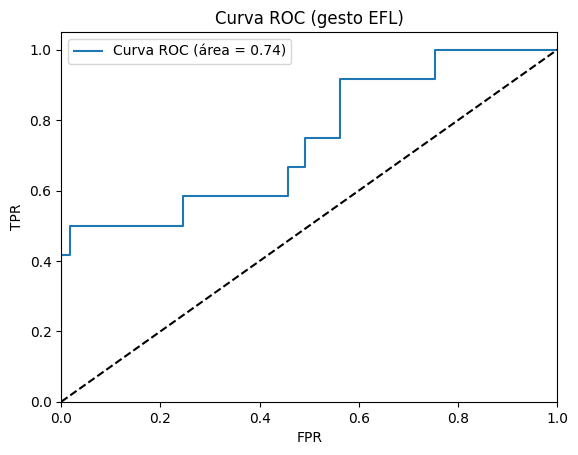

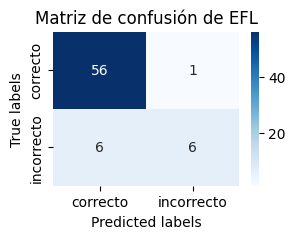

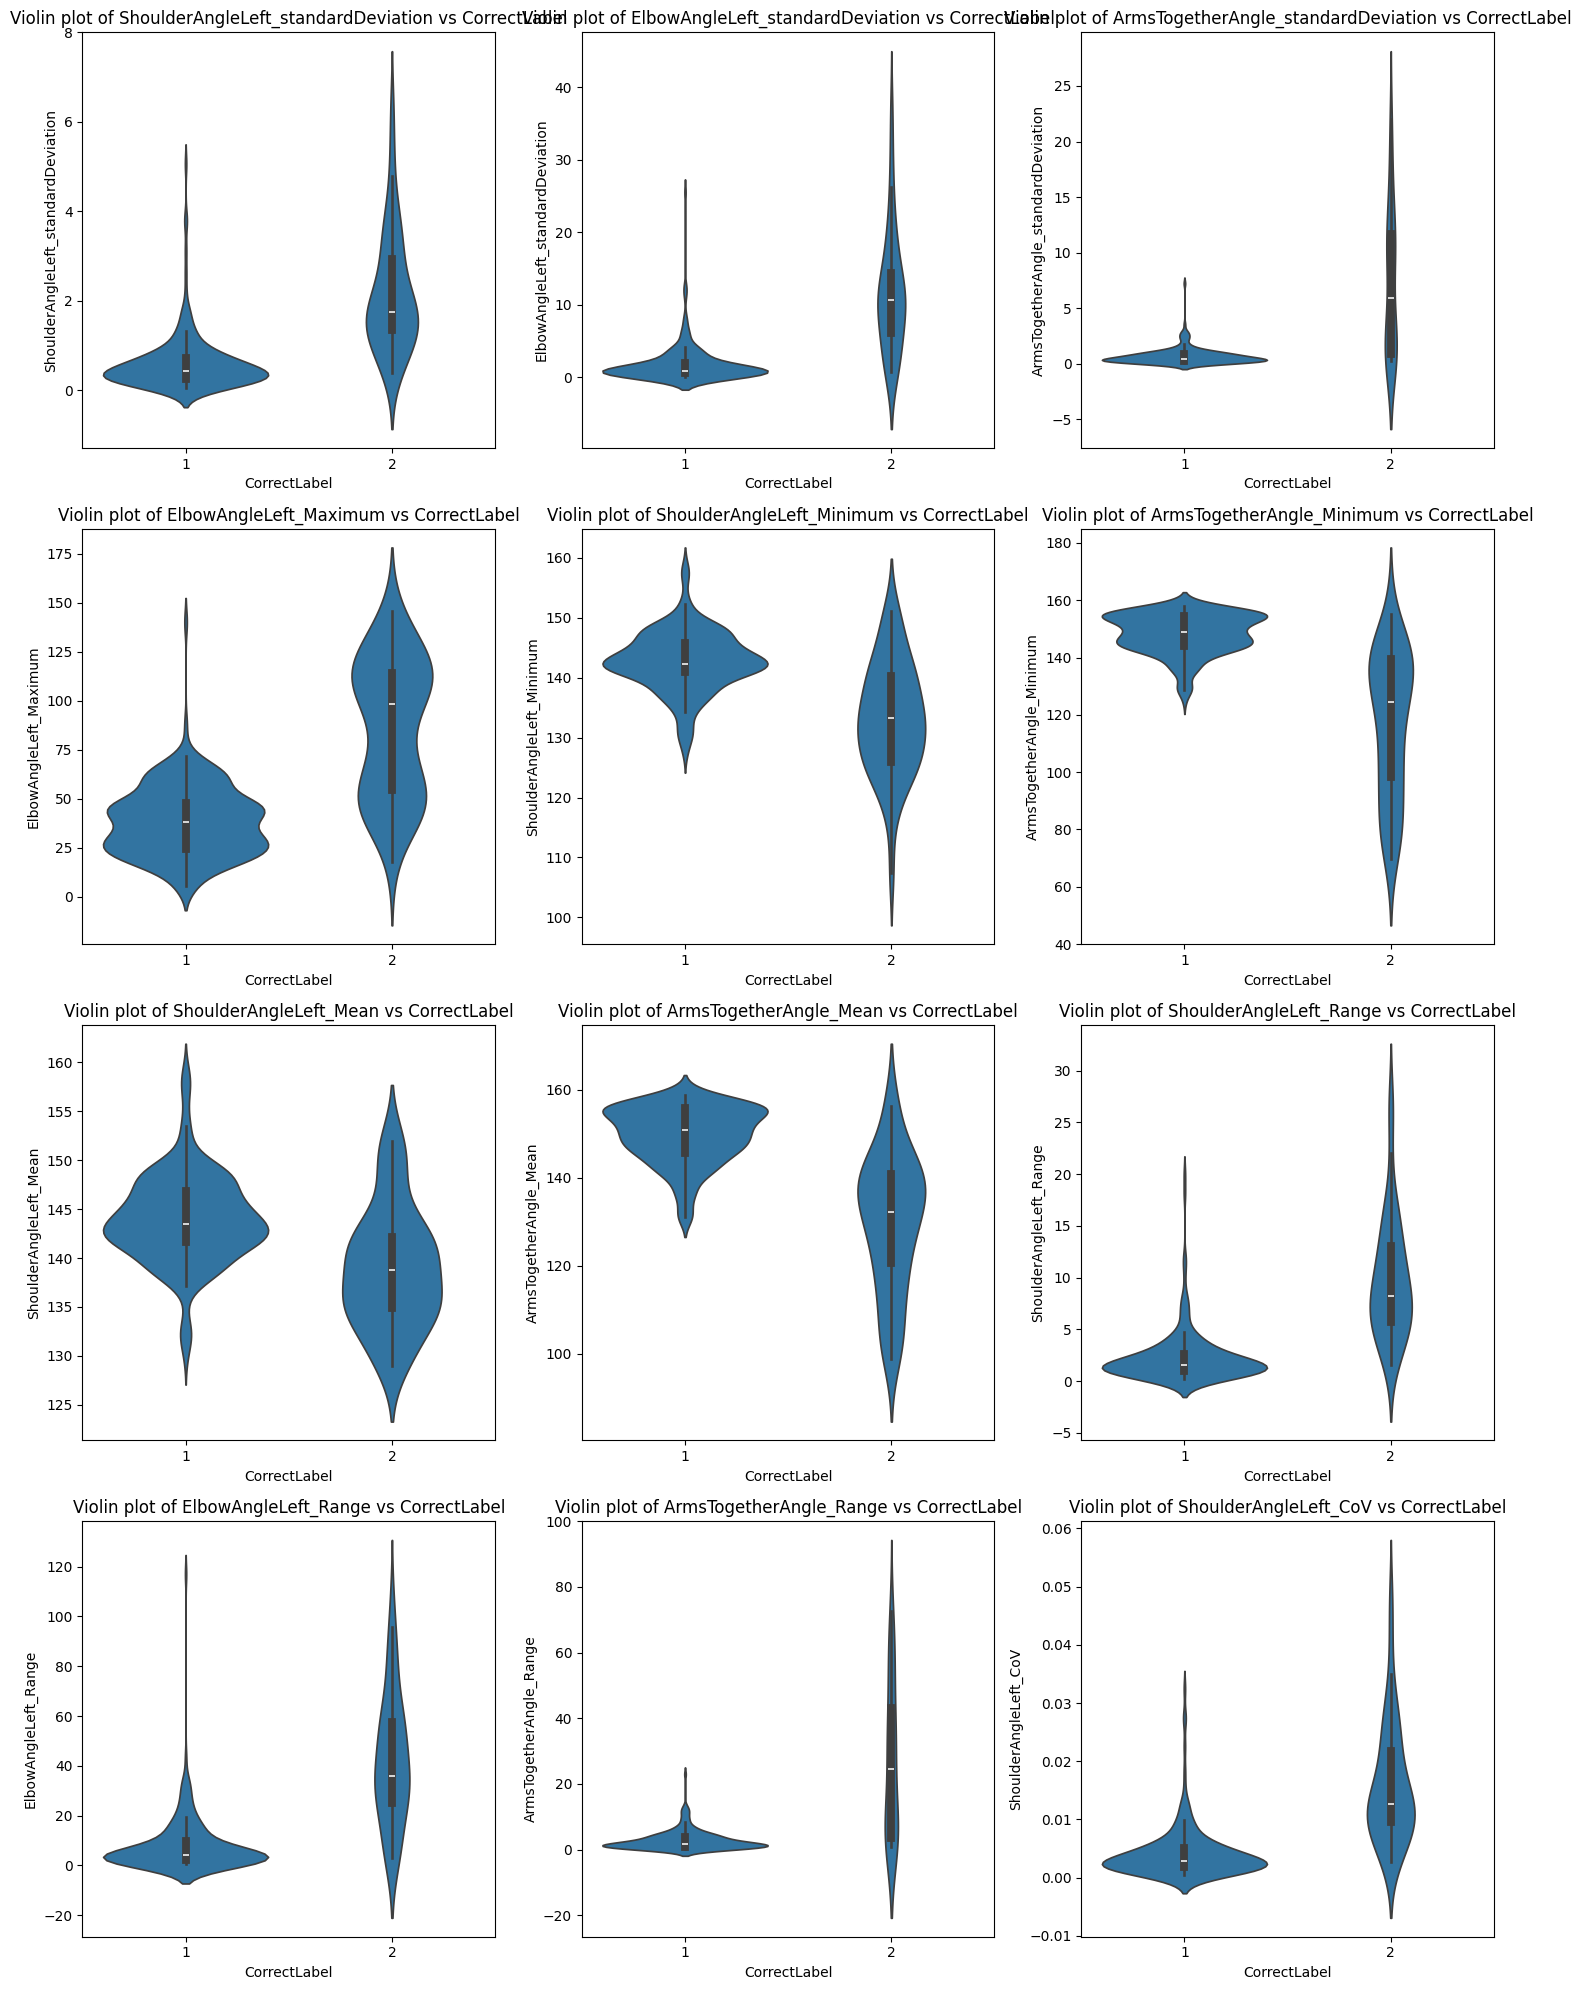


------------ CLASIFICACION GESTO EFR -----------

F1-score del conjunto de entrenamiento: 0.8435754189944135
F1-score del conjunto de prueba: 0.9080459770114943
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=5)),
                ('classifier', LogisticRegression(C=0.01, max_iter=500))])


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


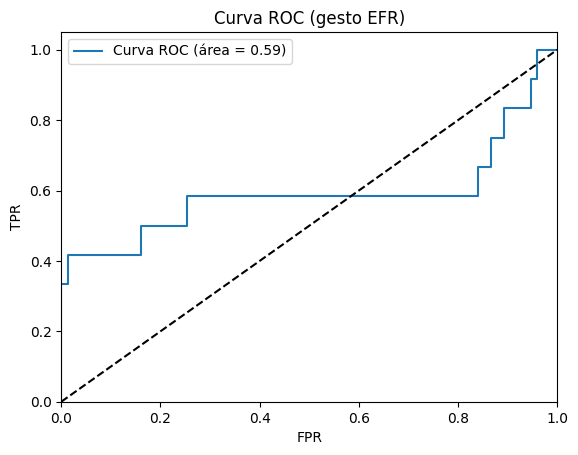

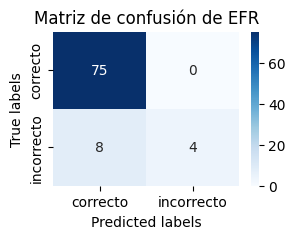

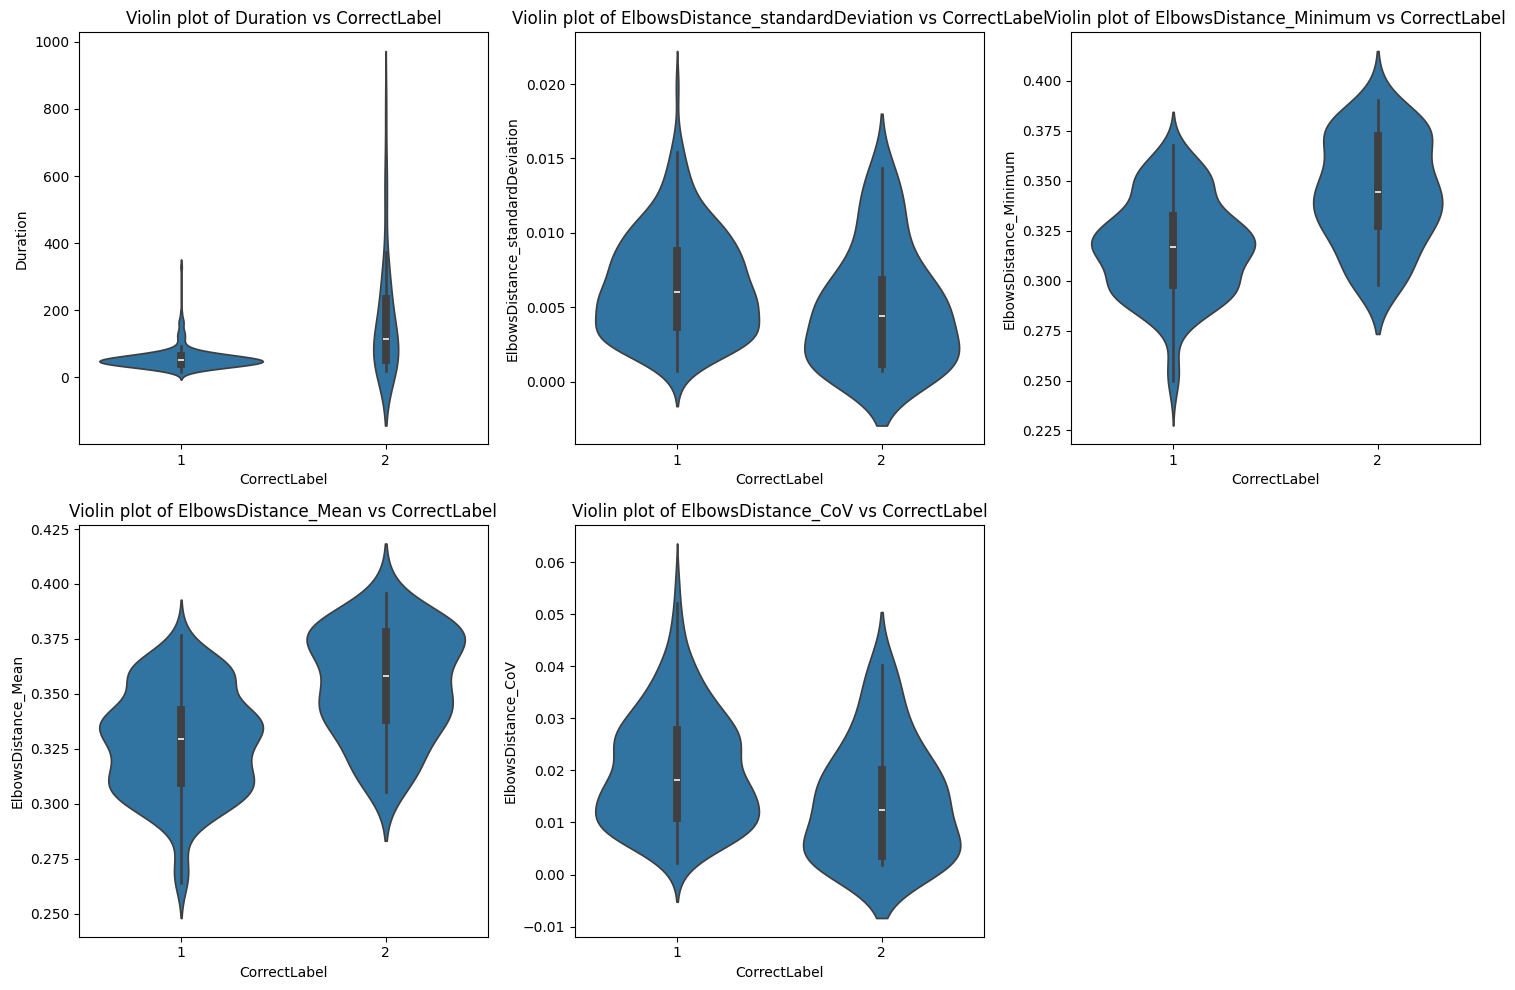


------------ CLASIFICACION GESTO SFL -----------

F1-score del conjunto de entrenamiento: 0.7718631178707225
F1-score del conjunto de prueba: 0.8910891089108911
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=14)),
                ('classifier',
                 GaussianNB(var_smoothing=2.848035868435799e-07))])


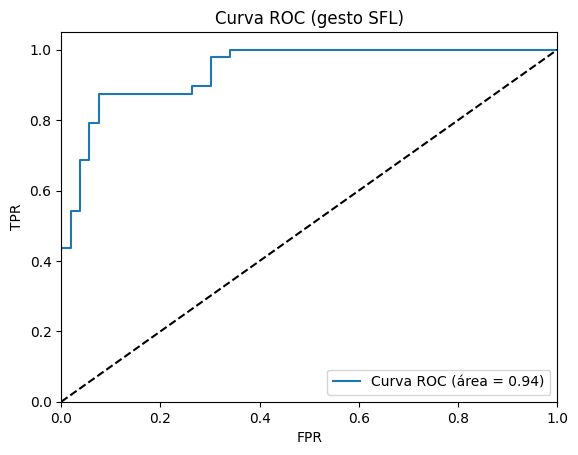

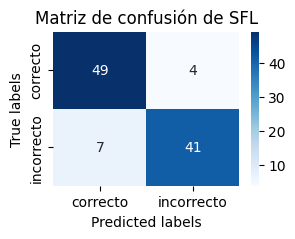

KeyError: "['stand'] not in index"

In [6]:
gestures = df_raw['GestureName'].unique()
logo = LeaveOneGroupOut()
results = []

for gesture in gestures:
    df_gesture = df_raw[df_raw['GestureName'] == gesture]

    angles = []

    #------- Calcular angulos y distancia segun gesto ---------
    if gesture == 'EFL' or gesture == 'SFL' or gesture == 'SAL' or gesture == 'SFE':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            elbow_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'ElbowLeft', 'WristLeft')
            left_arm_angle = fn.calculate_angle(group, 'HipLeft', 'ShoulderLeft', 'ElbowLeft')
            wrist_angle_left = fn.calculate_angle(group, 'ElbowLeft', 'WristLeft', 'HandLeft')
            arms_together_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristLeft')
            shoulder_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'SpineShoulder', 'ElbowLeft')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            # Almacenar la información en un diccionario
            angles.append({
                **additional_data,
                'ElbowAngleLeft': elbow_angle_left,
                'ShoulderAngleLeft': shoulder_angle_left,
                'WristAngleLeft': wrist_angle_left,
                'LeftArmAngle': left_arm_angle,
                'ArmsTogetherAngle': arms_together_angle,
                'ElbowsDistance': elbows_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })


    elif gesture == 'EFR'or gesture == 'SFR' or gesture == 'SAR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            elbow_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'ElbowRight', 'WristRight')
            right_arm_angle = fn.calculate_angle(group, 'HipRight', 'ShoulderRight', 'ElbowRight')
            wrist_angle_right = fn.calculate_angle(group, 'ElbowRight', 'WristRight', 'HandRight')
            arms_together_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristRight')
            shoulder_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'SpineShoulder', 'ElbowRight')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')

            angles.append({
                **additional_data,
                'ElbowAngleRight': elbow_angle_right,
                'ShoulderAngleRight': shoulder_angle_right,
                'WristAngleRight': wrist_angle_right,
                'RightArmAngle': right_arm_angle,
                'ArmsTogetherAngle': arms_together_angle,
                'ElbowsDistance': elbows_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STL':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            hip_angle_left = fn.calculate_angle(group, 'HipLeft', 'SpineBase', 'KneeLeft')
            knee_angle_left = fn.calculate_angle(group, 'HipLeft', 'KneeLeft', 'AnkleLeft')
            ankle_angle_left = fn.calculate_angle(group, 'KneeLeft', 'AnkleLeft', 'FootLeft')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleLeft': hip_angle_left,
                'KneeAngleLeft': knee_angle_left,
                'AnkleAngleLeft': ankle_angle_left,
                'ElbowsDistance': elbows_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            hip_angle_right = fn.calculate_angle(group, 'HipRight', 'SpineBase', 'KneeRight')
            knee_angle_right = fn.calculate_angle(group, 'HipRight', 'KneeRight', 'AnkleRight')
            ankle_angle_right = fn.calculate_angle(group, 'KneeRight', 'AnkleRight', 'FootRight')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleRight': hip_angle_right,
                'KneeAngleRight': knee_angle_right,
                'AnkleAngleRight': ankle_angle_right,
                'ElbowsDistance': elbows_distance,
                'HeadDistance': head_distance
            })

     
    # Crear un DataFrame a partir de la lista de diccionarios
    df_angles = pd.DataFrame(angles)

    # ---------- Agrupar por repeticion ----------
    # Agrupa el DataFrame 
    groups = df_angles.groupby(["SubjectID", "RepetitionNumber"])

    # Lista para almacenar los datos de salida
    data = []

    # Itera sobre cada grupo
    for (subject_id, repetition_number), group in groups:
        # Selecciona solo las columnas que contienen los ángulos 
        angles = group.iloc[:, 6:]

        # Calcula la media y la desviación estándar para los ángulos
        means = angles.mean()
        std_devs = angles.std()

        # Almacena las estadísticas en un diccionario 
        data.append({
            'SubjectID': subject_id,
            'RepetitionNumber': repetition_number,
            'CorrectLabel': group['CorrectLabel'].iloc[0],
            'Position': group['Position'].iloc[0],
            'Duration': len(group),  # Duración en número de frames
            'standardDeviation': std_devs,
            'Maximum': angles.max(),
            'Minimum': angles.min(),
            'Mean': means,
            'Range': angles.max() - angles.min(),
            'Variance': angles.var(),
            'CoV': std_devs / means,  # Coeficiente de variación
            'Skewness': angles.skew(),  # Asimetría
            'Kurtosis': angles.kurtosis()  # Curtosis
        })

    # Convierte la lista de diccionarios en un DataFrame y lo ordena
    df_stats = pd.DataFrame(data)
    df_stats = df_stats.apply(pd.to_numeric, errors='ignore')
    df_stats = df_stats.sort_values(['RepetitionNumber'])

    columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                    'Variance', 'CoV', 'Skewness', 'Kurtosis']

    nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col) for col in columnas], axis=1)

    df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)

    df_stats = df_stats.drop(columnas, axis=1)
    # cambiar las poorly executed to incorrectly executed
    df_stats.loc[df_stats['CorrectLabel'] == 3, 'CorrectLabel'] = 2

    # --------- Copia fase 2 ---------
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_stats, 'CorrectLabel')
    print(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')

    # Crear el pipeline con técnicas de balanceo, selección de características, reducción de dimensión y modelo de clasificación
    pipeline = ImbPipeline([
        ('preprocessing', ColumnTransformer(
                            transformers=[('encoder', OneHotEncoder(sparse_output=False), ['Position'])],
                            remainder='passthrough' ),
                        ),
        ('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))),
        ('select_features', SelectKBest(score_func=f_classif)),
        ('classifier', KNeighborsClassifier(n_neighbors=2))
    ])
    
    # RandomizedSearchCV para encontrar los mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=5, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_

    # Evaluar el modelo en el conjunto de entrenamiento y prueba
    f1_score_train = best_pipeline.score(X_train, y_train)
    f1_score_test = best_pipeline.score(X_test, y_test)
    print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
    print(f'F1-score del conjunto de prueba: {f1_score_test}')
    print(best_pipeline)
    
    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=2)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.figure()  
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture})')
    plt.legend()
    plt.show()

    # Matriz de confusión
    prediction = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index=['correcto', 'incorrecto'], columns=['correcto', 'incorrecto'])
    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión de {gesture}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

    # Variables seleccionadas
    preprocessor = best_pipeline.named_steps['preprocessing']
    feature_names = preprocessor.get_feature_names_out()

    select_kbest = best_pipeline.named_steps['select_features']

    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]
    selected_features = [name.replace('Position_', '') for name in selected_features]

    # Crear un DataFrame con las características seleccionadas y el target
    df_selected = df_stats[selected_features]
    y = df_stats['CorrectLabel']  # Variable objetivo

    # configure subplots
    n_features = len(selected_features)
    n_cols = 3  # Define how many columns per row
    n_rows = (n_features + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # Plot violin plots for each feature against the target
    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'Violin plot of {feature} vs CorrectLabel')
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show() 

    # Guardar resultados evaluacion
    results.append({
        'Gesto': gesture,
        'Classifier': best_pipeline.named_steps['classifier'].__class__.__name__,
        'K': select_kbest.k,
        'F1-score train': f1_score_train,
        'F1-score test': f1_score_test,
        'AUC': roc_auc
    })

In [ ]:
pd.DataFrame(results)

*****
## Variables seleccionadas y gráficas de correlaciones Fase 2

In [ ]:
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object)

In [ ]:
gestures = df['GestureName'].unique()

for gesture in gestures:

    df_gesture = df[df['GestureName'] == gesture]
    X = df_gesture.drop(['CorrectLabel'], axis=1)
    y = pd.DataFrame(df_gesture['CorrectLabel'])

    modelo_gesto_path = f'../Resultados/modelo_{gesture}.sav'
    best_pipeline, expected_columns = joblib.load(modelo_gesto_path)

    # Step 1: Get feature names from the 'preprocessing' step
    preprocessor = best_pipeline.named_steps['preprocessing']

    # Extract the feature names after preprocessing (OrdinalEncoder + remainder columns)
    feature_names = preprocessor.get_feature_names_out()

    # Step 2: Access the SelectKBest step and get the selected features
    select_kbest = best_pipeline.named_steps['select_features']

    # Get the boolean mask for the selected features
    selected_features_mask = select_kbest.get_support()

    # Use the mask to extract the selected feature names
    selected_features = feature_names[selected_features_mask]
    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]
    
    # Crear un DataFrame con las características seleccionadas y la variable objetivo
    selected_data = X[selected_features].copy()
    selected_data.loc[:, 'Target'] = y

    # Calcular la correlación entre cada característica seleccionada y la variable objetivo
    correlations = selected_data.corr()['Target'].drop('Target')  # Excluir la correlación consigo mismo

    # Visualizar las correlaciones en un gráfico de barras
    plt.figure(figsize=(10, 8))
    correlations.sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Correlación de características seleccionadas con el target para {gesture}')
    plt.ylabel('Correlación')
    plt.xlabel('Características')
    plt.ylim(-1, 1)
    plt.show()